In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
df = pd.read_csv('Food_Inspections_20250216.csv')

metainfo of the data

In [ ]:
df.shape
df.dtypes

In [ ]:
df.head()

# single column profiling
## missing values

In [ ]:
missing_values = df.isnull().sum()
missing_values

## column: facility tpye

In [ ]:
facility_counts = df['Facility Type'].value_counts()
facility_counts

## Column Risk

In [ ]:
risk_counts = df['Risk'].value_counts()
risk_counts
plt.figure(figsize=(8, 6))
risk_counts.plot(kind='bar')

## column inspection_type

In [ ]:
inspection_type_counts = df['Inspection Type'].value_counts()
inspection_type_counts

## Column: violation

In [ ]:
violation_counts = df['Violations'].value_counts()
violation_counts

## column: inspertion data 

In [ ]:
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'], format="%m/%d/%Y", errors='coerce')

In [ ]:
df['Year'] = df['Inspection Date'].dt.year
df['Month'] = df['Inspection Date'].dt.month

# 按年份统计通过率
yearly_results = pd.crosstab(df['Year'], df['Results'])
yearly_pass_rate = yearly_results['Pass'] / yearly_results.sum(axis=1) * 100
yearly_pass_rate.plot(kind='line',marker = 'o')

## results

In [ ]:
result_counts = df['Results'].value_counts()
result_counts

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(df['Longitude'], df['Latitude'], alpha=0.5, s=5)
plt.title('geographic_distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()


In [ ]:

risk_result = pd.crosstab(df['Risk'], df['Results'], normalize='index') * 100
plt.figure(figsize=(12, 6))
risk_result.plot(kind='bar', stacked=True)
plt.tight_layout()

# association rules between columns


## data structuring

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
import re
from datetime import datetime
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df = pd.read_csv('Food_Inspections_20250216.csv')

In [ ]:
def extract_violation_codes(text):
    if pd.isna(text):
        return []
    # 提取违规代码 (例如: 32, 10, 47 等)
    codes = re.findall(r"\b(\d+)\.(?=\s+[A-Z])", text)
    return codes

In [ ]:
transactions = []
for idx, row in df.iterrows():
    transaction = {
        'Facility_Type': row['Facility Type'],
        'Risk': row['Risk'],
        'Results': row['Results'],
        'Inspection_Type': row['Inspection Type']
    }

    # 添加违规代码
    if not pd.isna(row['Violations']):
        violation_codes = extract_violation_codes(row['Violations'])
        for code in violation_codes:
            transaction[f'Violation_{code}'] = 1

    transactions.append(transaction)

In [ ]:
trans_df = pd.DataFrame(transactions)

In [ ]:
trans_df.head()

In [ ]:
# 填充缺失值为0（表示没有该违规）
for col in trans_df.columns:
    if col.startswith('Violation_'):
        trans_df[col] = trans_df[col].fillna(0)

In [ ]:
categorical_cols = ['Facility_Type', 'Risk', 'Results', 'Inspection_Type']
for col in categorical_cols:
    dummies = pd.get_dummies(trans_df[col], prefix=col)
    trans_df = pd.concat([trans_df, dummies], axis=1)
    trans_df.drop(col, axis=1, inplace=True)


In [ ]:
trans_df.head()

In [ ]:
trans_df = trans_df.astype(int)

## find association rules between violation

In [ ]:
# 1. 分析违规代码之间的关联规则
# 只选择违规代码列
violation_cols = [col for col in trans_df.columns if col.startswith('Violation_')]
violation_df = trans_df[violation_cols]

In [ ]:
# 应用Apriori算法找出频繁项集
frequent_itemsets = apriori(violation_df, min_support=0.1, use_colnames=True)

In [ ]:
frequent_itemsets.sort_values(ascending=False, by= 'support')

In [ ]:
# 从频繁项集生成关联规则
violation_rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
print("association rules between violations:")
if len(violation_rules) > 0:
    sorted_rules = violation_rules.sort_values('lift', ascending=False)
    for i, rule in sorted_rules.head(10).iterrows():
        antecedent = ", ".join([item.replace('Violation_', 'violation') for item in list(rule['antecedents'])])
        consequent = ", ".join([item.replace('Violation_', 'violation') for item in list(rule['consequents'])])
        print(f"{antecedent} => {consequent} (support: {rule['support']:.3f}, confidence: {rule['confidence']:.3f}, lift: {rule['lift']:.3f})")
else:
    print("no association rules found")

## find association rules between facility type, risk, and results

In [ ]:
category_cols = [col for col in trans_df.columns if
                 col.startswith('Facility_Type_') or
                 col.startswith('Risk_') or
                 col.startswith('Results_')]
category_df = trans_df[category_cols]

In [ ]:
frequent_itemsets_cat = apriori(category_df, min_support=0.05, use_colnames=True)

In [ ]:
frequent_itemsets_cat.sort_values(ascending=False, by= 'support')

In [ ]:
category_rules = association_rules(frequent_itemsets_cat, metric="lift", min_threshold=1.0)

In [ ]:
print("\nassociation rules between facility type, risk, and results")
if len(category_rules) > 0:
    sorted_rules = category_rules.sort_values('lift', ascending=False)
    for i, rule in sorted_rules.head(10).iterrows():
        antecedent = ", ".join([item for item in list(rule['antecedents'])])
        consequent = ", ".join([item for item in list(rule['consequents'])])
        print(f"{antecedent} => {consequent} (support: {rule['support']:.3f}, confidence: {rule['confidence']:.3f}, lift: {rule['lift']:.3f})")
else:
    print("no association rules found")

## association rules between facility and violation

In [ ]:
facility_violation_cols = [col for col in trans_df.columns if
                           col.startswith('Facility_Type_') or
                           col.startswith('Violation_')]
facility_violation_df = trans_df[facility_violation_cols]

In [ ]:
frequent_itemsets_fv = apriori(facility_violation_df, min_support=0.02, use_colnames=True)

In [ ]:
frequent_itemsets_fv.sort_values(ascending=False, by= 'support')

In [ ]:
fv_rules = association_rules(frequent_itemsets_fv, metric="confidence", min_threshold=0.05)


In [ ]:
print("\nassociation rules between facility and violation")
if len(fv_rules) > 0:
    sorted_rules = fv_rules.sort_values('lift', ascending=False)
    # 只选择从设施类型到违规代码的规则
    facility_to_violation_rules = sorted_rules[sorted_rules['antecedents'].apply(lambda x: all('Facility_Type_' in item for item in x)) &
                                               sorted_rules['consequents'].apply(lambda x: all('Violation_' in item for item in x))]

    if len(facility_to_violation_rules) > 0:
        for i, rule in facility_to_violation_rules.head(10).iterrows():
            antecedent = ", ".join([item.replace('Facility_Type_', 'facility_type:') for item in list(rule['antecedents'])])
            consequent = ", ".join([item.replace('Violation_', 'violation') for item in list(rule['consequents'])])
            print(f"{antecedent} => {consequent} (support: {rule['support']:.3f}, confidence: {rule['confidence']:.3f}, lift: {rule['lift']:.3f})")
    else:
        print("no association rules between facility and violation found")
else:
    print("no association rules between facility and violation")

In [ ]:
if len(violation_rules) > 0:
    plt.figure(figsize=(12, 10))
    G = nx.DiGraph()

    # 选择提升度最高的前20条规则
    top_rules = violation_rules.sort_values('lift', ascending=False).head(20)

    # 添加节点和边
    for i, rule in top_rules.iterrows():
        for item in rule['antecedents']:
            G.add_node(item.replace('Violation_', 'violation'))
        for item in rule['consequents']:
            G.add_node(item.replace('Violation_', 'violation'))

        for a_item in rule['antecedents']:
            for c_item in rule['consequents']:
                G.add_edge(a_item.replace('Violation_', 'violation'),
                           c_item.replace('Violation_', 'violation'),
                           weight=rule['lift'])

    # 绘制网络图
    pos = nx.spring_layout(G, seed=42)
    edges = G.edges()
    weights = [G[u][v]['weight'] * 2 for u, v in edges]

    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000,
            font_size=10, font_weight='bold', edge_color='gray',
            width=weights, edge_cmap=plt.cm.Blues, arrows=True,
            connectionstyle='arc3,rad=0.1')

    plt.title('network of high related violation codes')
    plt.savefig('violation_association_network.png', dpi=300)
    plt.show()



# functional dependencies discovery

## TANE, based on https://github.com/codocedo/tane/blob/master/tane.py 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from collections import defaultdict
from itertools import combinations
import sys
from tqdm import tqdm

In [2]:
from tane import TANE, PPattern, read_db, tostr
tane_imported = True

In [4]:
#url = "https://data.cityofchicago.org/api/views/4ijn-s7e5/rows.csv?accessType=DOWNLOAD"

df = pd.read_csv('cleaned_dataset_for_FD.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287237 entries, 0 to 287236
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   inspection_id    287237 non-null  int64  
 1   dba_name         287237 non-null  object 
 2   aka_name         287237 non-null  object 
 3   license_num      287219 non-null  float64
 4   facility_type    282040 non-null  object 
 5   risk             287237 non-null  object 
 6   address          287237 non-null  object 
 7   city             287237 non-null  object 
 8   state            287237 non-null  object 
 9   inspection_date  287237 non-null  object 
 10  inspection_type  287236 non-null  object 
 11  results          287237 non-null  object 
 12  violations       207585 non-null  object 
 13  latitude         287066 non-null  float64
 14  longitude        287066 non-null  float64
 15  location         287066 non-null  object 
 16  zip              287198 non-null  floa

In [7]:
columns_to_exclude = ['violations']
# Select subset of columns to speed up algorithm
df_analysis = df.drop(columns=columns_to_exclude)
df_analysis = df_analysis.dropna()
float_cols = df.select_dtypes(include=["float64"]).columns
df[float_cols] = df[float_cols].astype(str)

In [8]:
sample_size = 1000000  # Adjust as needed
if len(df_analysis) > sample_size:
    print(f"Using {sample_size} random sample rows to speed up processing...")
    df_sample = df_analysis.sample(sample_size, random_state=42)
else:
    df_sample = df_analysis

In [9]:
def convert_to_tane_input(df):
    """
    Convert pandas DataFrame to TANE input format (list of stripped partitions)
    """
    partitions = []
    for col_idx in range(df.shape[1]):
        # Group records by column values
        value_dict = {}
        for row_idx, value in enumerate(df.iloc[:, col_idx]):
            if value not in value_dict:
                value_dict[value] = set()
            value_dict[value].add(row_idx)

        # Keep only partitions with more than one row
        partition = [indices for indices in value_dict.values() if len(indices) > 1]

        # If PPattern is available, use its fix_desc method
        if 'PPattern' in globals():
            partition = PPattern.fix_desc(partition)

        partitions.append(partition)

    return partitions

In [10]:
def run_tane_via_module(df):
    """
    Run TANE algorithm by directly using the imported module
    """
    # Convert data to TANE format
    tane_input = convert_to_tane_input(df)

    # Create TANE instance and run
    tane_instance = TANE(tane_input)
    start_time = time.time()
    tane_instance.run()
    end_time = time.time()

    # Get results and convert to tuple format with column names
    dependencies = []
    for lhs, rhs in tane_instance.rules:
        # Convert attribute indices to column names
        if isinstance(lhs, tuple):
            lhs_cols = tuple(df.columns[i] for i in lhs)
        else:
            lhs_cols = df.columns[lhs]
        rhs_col = df.columns[rhs]

        # Calculate dependency strength (always 1.0 for TANE as it finds exact dependencies)
        dependencies.append((lhs_cols, rhs_col, 1.0))

    return dependencies, end_time - start_time

In [12]:
def visualize_dependencies(deps, title):
    """
    Visualize discovered functional dependencies as a network graph
    """
    print(f"\nVisualizing {len(deps)} functional dependencies...")

    G = nx.DiGraph()

    # Create nodes and edges
    for lhs, rhs, strength in deps:
        # Handle both single attribute and multi-attribute LHS
        if isinstance(lhs, tuple):
            # For multiple attributes on LHS, create a combined node
            lhs_label = " + ".join(str(attr) for attr in lhs)
            G.add_node(lhs_label, shape='box', style='filled', fillcolor='lightblue')

            # Also add individual attribute nodes and connect them to the combined node
            for attr in lhs:
                if attr not in G:
                    G.add_node(attr, shape='ellipse')
                G.add_edge(attr, lhs_label, style='dashed', weight=0.5)

            # Connect the combined node to RHS
            G.add_edge(lhs_label, rhs, width=strength*3, weight=strength, label=f"{strength:.2f}")
        else:
            # For single attribute, connect directly
            if lhs not in G:
                G.add_node(lhs, shape='ellipse')
            if rhs not in G:
                G.add_node(rhs, shape='ellipse')
            G.add_edge(lhs, rhs, width=strength*3, weight=strength, label=f"{strength:.2f}")

    # Draw the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, k=0.8, iterations=100)

    # Draw nodes
    node_shapes = nx.get_node_attributes(G, 'shape')
    for shape in set(node_shapes.values()):
        nodes = [node for node, s in node_shapes.items() if s == shape]
        if shape == 'box':
            nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color='lightblue',
                                   node_size=3000, node_shape='s')
        else:
            nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color='lightgreen',
                                   node_size=2000, node_shape='o')

    # Draw edges
    edge_widths = [G[u][v].get('width', 1) for u, v in G.edges()]
    edge_styles = [G[u][v].get('style', 'solid') for u, v in G.edges()]

    solid_edges = [(u, v) for (u, v), style in zip(G.edges(), edge_styles) if style == 'solid']
    dashed_edges = [(u, v) for (u, v), style in zip(G.edges(), edge_styles) if style == 'dashed']

    if solid_edges:
        nx.draw_networkx_edges(G, pos, edgelist=solid_edges, width=edge_widths[:len(solid_edges)])
    if dashed_edges:
        nx.draw_networkx_edges(G, pos, edgelist=dashed_edges, width=1, style='dashed')

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='SimHei')

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()

    # Save figure
    plt.savefig(f'{title.replace(" ", "_")}.png', dpi=300)
    plt.show()

In [13]:
def analyze_important_columns(deps, important_columns=None):
    """
    Analyze dependencies for important columns
    """
    print("\n========= Important Attribute Dependency Analysis =========")

    if important_columns is None:
        # If not specified, analyze the 5 most active columns
        column_involvement = defaultdict(int)
        for X, Y, _ in deps:
            if isinstance(X, tuple):
                for x in X:
                    column_involvement[x] += 1
            else:
                column_involvement[X] += 1
            column_involvement[Y] += 1

        important_columns = [col for col, _ in sorted(column_involvement.items(),
                                                      key=lambda x: x[1], reverse=True)[:5]]

    for col in important_columns:
        # As determining attribute
        determined = []
        for X, Y, strength in deps:
            if isinstance(X, tuple) and col in X:
                determined.append((X, Y, strength))
            elif X == col:
                determined.append((X, Y, strength))

        if determined:
            print(f"\nAttribute '{col}' helps determine these attributes:")
            for X, Y, strength in sorted(determined, key=lambda x: x[2], reverse=True):
                print(f"  {X} → {Y} (strength: {strength:.4f})")

        # As determined attribute
        determining = [(X, Y, strength) for X, Y, strength in deps if Y == col]
        if determining:
            print(f"\nThese attributes determine '{col}':")
            for X, Y, strength in sorted(determining, key=lambda x: x[2], reverse=True):
                print(f"  {X} → {Y} (strength: {strength:.4f})")

In [ ]:
# 运行TANE算法
print("Running TANE via direct module import...")
start = time.time()
dependencies, runtime = run_tane_via_module(df_sample)
print(f"\nTANE algorithm runtime: {runtime:.2f} seconds")
print(f"Total functional dependencies discovered: {len(dependencies)}")

Running TANE via direct module import...


In [44]:
# 打印部分发现的依赖关系
if dependencies:
    print("\nSome functional dependencies discovered by TANE algorithm:")
    for dep in sorted(dependencies, key=lambda x: x[2], reverse=True)[:15]:
        X_str = str(dep[0])
        print(f"{X_str} → {dep[1]} (strength: {dep[2]:.4f})")


Some functional dependencies discovered by TANE algorithm:
('Inspection ID',) → DBA Name (strength: 1.0000)
('Inspection ID',) → AKA Name (strength: 1.0000)
('Inspection ID',) → License # (strength: 1.0000)
('Inspection ID',) → Facility Type (strength: 1.0000)
('Inspection ID',) → Risk (strength: 1.0000)
('Inspection ID',) → City (strength: 1.0000)
('Inspection ID',) → State (strength: 1.0000)
('Inspection ID',) → Zip (strength: 1.0000)
('Inspection ID',) → Inspection Type (strength: 1.0000)
('Inspection ID',) → Results (strength: 1.0000)
('License #',) → State (strength: 1.0000)
('AKA Name',) → State (strength: 1.0000)
('DBA Name',) → State (strength: 1.0000)
('DBA Name', 'License #') → City (strength: 1.0000)
('AKA Name', 'License #') → City (strength: 1.0000)



Visualizing 39 functional dependencies...


findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

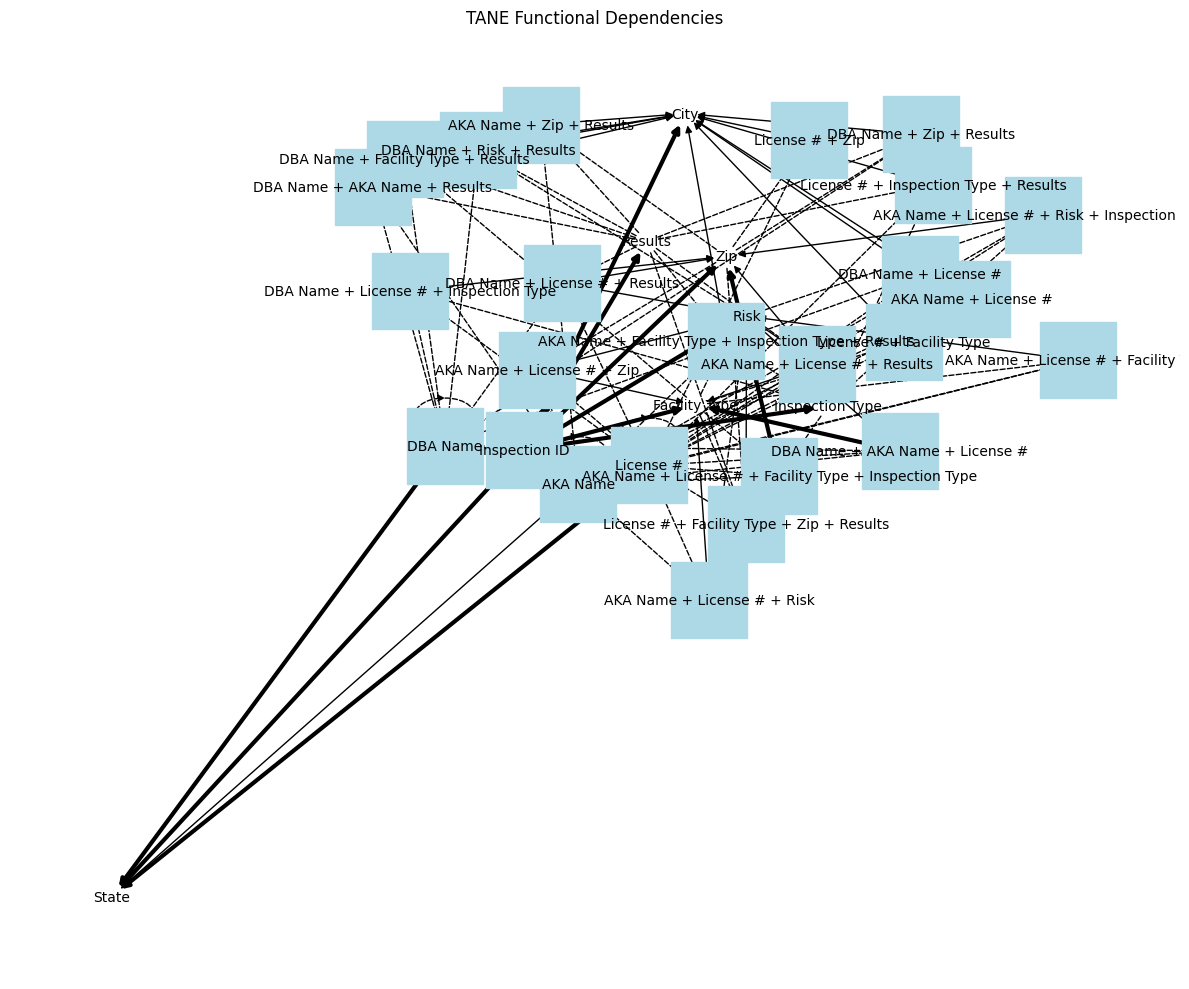

In [45]:
# 可视化依赖关系
if dependencies:
    visualize_dependencies(dependencies, "TANE Functional Dependencies")

In [46]:
# 分析重要列
if dependencies:
    important_columns = ['Inspection ID', 'License #', 'Facility Type', 'Risk', 'Results']
    analyze_important_columns(dependencies, important_columns)
else:
    print("No functional dependencies discovered or unable to parse results.")


========= Important Attribute Dependency Analysis =========

Attribute 'Inspection ID' helps determine these attributes:
  ('Inspection ID',) → DBA Name (strength: 1.0000)
  ('Inspection ID',) → AKA Name (strength: 1.0000)
  ('Inspection ID',) → License # (strength: 1.0000)
  ('Inspection ID',) → Facility Type (strength: 1.0000)
  ('Inspection ID',) → Risk (strength: 1.0000)
  ('Inspection ID',) → City (strength: 1.0000)
  ('Inspection ID',) → State (strength: 1.0000)
  ('Inspection ID',) → Zip (strength: 1.0000)
  ('Inspection ID',) → Inspection Type (strength: 1.0000)
  ('Inspection ID',) → Results (strength: 1.0000)

Attribute 'License #' helps determine these attributes:
  ('License #',) → State (strength: 1.0000)
  ('DBA Name', 'License #') → City (strength: 1.0000)
  ('AKA Name', 'License #') → City (strength: 1.0000)
  ('License #', 'Facility Type') → City (strength: 1.0000)
  ('License #', 'Zip') → City (strength: 1.0000)
  ('AKA Name', 'License #', 'Results') → Risk (strength

## Approximate FD



import pandas as pd

data = pd.DataFrame({
    'Dept': ['Sales', 'Sales', 'Sales', 'Finance', 'Finance'],
    'Manager': ['Alice', 'Alice', 'Bob', 'Claire', 'Claire'],
    'ID': [1, 2, 3, 4, 5]
})
from openclean.pipeline import stream

ds = stream(data)


#  inclusion dependencies 

In [47]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from collections import defaultdict



## brute force

In [48]:
def find_inclusion_dependencies(df, min_confidence=0.95):
    """
    Find inclusion dependencies between columns in a DataFrame
    
    Parameters:
    -----------
    df : pandas DataFrame
        The data to analyze
    min_confidence : float, default=0.95
        Minimum confidence threshold for inclusion dependencies
        
    Returns:
    --------
    list of tuples (A, B, confidence)
        A ⊆ B with confidence score
    """
    print("Finding inclusion dependencies...")
    start_time = time.time()

    # Get unique values for each column
    unique_values = {}
    for col in df.columns:
        unique_values[col] = set(df[col].dropna().unique())

    dependencies = []
    total_comparisons = len(df.columns) * (len(df.columns) - 1)

    # Check each pair of columns
    for i, col_a in enumerate(df.columns):
        for col_b in df.columns:
            if col_a != col_b:
                # Skip if col_a has no values
                if not unique_values[col_a]:
                    continue

                # Check if values in col_a are subset of values in col_b
                overlap = unique_values[col_a].intersection(unique_values[col_b])
                confidence = len(overlap) / len(unique_values[col_a])

                # If confidence meets threshold, record dependency
                if confidence >= min_confidence:
                    dependencies.append((col_a, col_b, confidence))

        # Progress update
        if (i+1) % 5 == 0 or (i+1) == len(df.columns):
            progress = (i+1) * (len(df.columns) - 1) / total_comparisons * 100
            print(f"Progress: {progress:.1f}% ({i+1}/{len(df.columns)} columns processed)")

    print(f"Found {len(dependencies)} inclusion dependencies in {time.time() - start_time:.2f} seconds")
    return dependencies

In [49]:
def visualize_inclusion_dependencies(deps, title):
    """
    Visualize discovered inclusion dependencies as a network graph
    """
    print(f"\nVisualizing {len(deps)} inclusion dependencies...")

    G = nx.DiGraph()

    # Create nodes and edges
    for col_a, col_b, confidence in deps:
        if col_a not in G:
            G.add_node(col_a, shape='ellipse')
        if col_b not in G:
            G.add_node(col_b, shape='ellipse')

        # Edge from A to B means A ⊆ B
        G.add_edge(col_a, col_b, width=confidence*3, weight=confidence,
                   label=f"{confidence:.2f}")

    # Draw the graph
    plt.figure(figsize=(12, 10))

    # Use hierarchical layout for better visualization of inclusion relationships
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    except:
        # Fallback to spring layout if graphviz is not available
        pos = nx.spring_layout(G, k=0.8, iterations=100)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=2000, node_shape='o')

    # Draw edges with varying width based on confidence
    edge_widths = [G[u][v].get('width', 1) for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=edge_widths,
                           edge_color='blue', alpha=0.7,
                           arrowsize=20, connectionstyle='arc3,rad=0.1')

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='SimHei')

    # Edge labels (confidences)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()

    # Save figure
    plt.savefig(f'{title.replace(" ", "_")}.png', dpi=300)
    plt.show()

In [50]:
def analyze_inclusion_dependencies(deps):
    """
    Analyze inclusion dependencies to extract insights
    """
    print("\n========= Inclusion Dependency Analysis =========")

    # Find columns that are subsets of many other columns
    subset_counts = defaultdict(int)
    for col_a, _, _ in deps:
        subset_counts[col_a] += 1

    # Find columns that contain many other columns
    superset_counts = defaultdict(int)
    for _, col_b, _ in deps:
        superset_counts[col_b] += 1

    # Print top columns that are subsets of others
    print("\nTop columns that are subsets of others (potential foreign keys):")
    for col, count in sorted(subset_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {col}: contained in {count} other columns")

    # Print top columns that contain others
    print("\nTop columns that contain other columns (potential reference tables):")
    for col, count in sorted(superset_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {col}: contains {count} other columns")

    # Find chains of inclusion dependencies
    print("\nChains of inclusion dependencies (transitive relationships):")
    for a, b, conf_ab in deps:
        for c, d, conf_cd in deps:
            if b == c and a != d:
                print(f"  {a} ⊆ {b} ⊆ {d} (confidence: {conf_ab:.2f}, {conf_cd:.2f})")

    # Find bidirectional (equivalent) dependencies
    print("\nBidirectional dependencies (equivalent columns):")
    bidirectional = []
    for a, b, conf_ab in deps:
        for c, d, conf_cd in deps:
            if a == d and b == c and a != b and (a, b) not in bidirectional and (b, a) not in bidirectional:
                bidirectional.append((a, b))
                print(f"  {a} ≡ {b} (confidence: {conf_ab:.2f}, {conf_cd:.2f})")

In [51]:
columns_to_exclude = ['Violations' ]
# 选择一部分列来加快算法执行速度
columns_to_include = ['Inspection ID', 'DBA Name', 'AKA Name', 'License #',
                      'Facility Type', 'Risk', 'City', 'State', 'Zip',
                      'Inspection Type', 'Results','Location']
df_analysis = df.drop(columns=columns_to_exclude)[columns_to_include]
df_analysis = df_analysis.fillna('__NULL__')

In [52]:
sample_size = 1000  # 可根据需要调整
if len(df_analysis) > sample_size:
    print(f"Using {sample_size} random sample rows to speed up processing...")
    df_sample = df_analysis.sample(sample_size, random_state=42)
else:
    df_sample = df_analysis

Using 1000 random sample rows to speed up processing...


In [53]:
# 发现包含依赖
inclusion_deps = find_inclusion_dependencies(df_sample, min_confidence=0.95)

# 打印一些发现的包含依赖
if inclusion_deps:
    print("\nSome inclusion dependencies discovered:")
    for dep in sorted(inclusion_deps, key=lambda x: x[2], reverse=True)[:10]:
        print(f"{dep[0]} ⊆ {dep[1]} (confidence: {dep[2]:.4f})")

Finding inclusion dependencies...
Progress: 41.7% (5/12 columns processed)
Progress: 83.3% (10/12 columns processed)
Progress: 100.0% (12/12 columns processed)
Found 0 inclusion dependencies in 0.00 seconds


# data quality

In [54]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import missingno as msno
from collections import defaultdict

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# Basic statistical information
print("Basic statistical information:")
df.describe(include='all').T

In [ ]:
# Missing value analysis
print("Missing value analysis:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage.round(2)
})
missing_df = missing_df.sort_values('Missing Percentage', ascending=False)

# Display missing value information
print(missing_df)

# Visualize missing values
plt.figure(figsize=(12, 8))
msno.matrix(df)
plt.title("Missing Value Pattern Matrix")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
msno.bar(df)
plt.title("Missing Value Percentage by Column")
plt.tight_layout()
plt.show()

# Missing value correlation heatmap
plt.figure(figsize=(12, 10))
msno.heatmap(df)
plt.title("Missing Value Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
# Check for completely duplicate records
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of completely duplicate rows: {duplicate_rows}")

# Check for duplicates in specific column combinations
if 'Inspection ID' in df.columns:
    inspection_id_duplicates = df.duplicated('Inspection ID').sum()
    print(f"Number of duplicate Inspection IDs: {inspection_id_duplicates}")

    if inspection_id_duplicates > 0:
        print("\nExamples of duplicate Inspection IDs:")
        duplicate_ids = df[df.duplicated('Inspection ID', keep=False)]['Inspection ID'].unique()
        print(df[df['Inspection ID'].isin(duplicate_ids[:5])].sort_values('Inspection ID'))

In [ ]:
# Check value consistency for categorical variables
categorical_columns = ['Facility Type', 'Risk', 'City', 'State', 'Inspection Type', 'Results']
for col in categorical_columns:
    if col in df.columns:
        value_counts = df[col].value_counts()

        print(f"\nValue distribution for column '{col}':")
        print(value_counts.head(10))

        # Check for spelling errors and inconsistent values
        if len(value_counts) > 20:
            print(f"Warning: Column '{col}' has {len(value_counts)} different values, possible spelling errors or inconsistencies")

            # Try to identify similar values
            from difflib import get_close_matches
            all_values = value_counts.index.tolist()
            similar_values = {}

            for val in all_values[:20]:  # Only check the top 20 common values
                matches = get_close_matches(val, all_values, n=3, cutoff=0.8)
                if len(matches) > 1:  # Exclude self
                    similar_values[val] = [m for m in matches if m != val]

            if similar_values:
                print("Possibly similar values:")
                for val, matches in similar_values.items():
                    count_val = value_counts[val]
                    counts_matches = [f"{m} ({value_counts[m]})" for m in matches]
                    print(f"  {val} ({count_val}) similar to: {', '.join(counts_matches)}")

In [ ]:
# Check potential referential integrity issues
fk_pairs = []

# Check relationship between License # and facility name
if 'License #' in df.columns and 'DBA Name' in df.columns:
    fk_pairs.append(('License #', 'DBA Name'))

# Check relationship between City and State
if 'City' in df.columns and 'State' in df.columns:
    fk_pairs.append(('City', 'State'))

for fk, pk in fk_pairs:
    print(f"\nChecking referential integrity between {fk} and {pk}:")

    # For each foreign key value, there should be only one primary key value
    fk_to_pk = df.groupby(fk)[pk].nunique()
    inconsistent = fk_to_pk[fk_to_pk > 1]

    if len(inconsistent) > 0:
        print(f"Found {len(inconsistent)} {fk} values mapping to multiple {pk} values")
        print("Examples:")
        for fk_val in inconsistent.index[:5]:
            print(f"  {fk} = {fk_val}:")
            print(f"    Corresponding {pk} values: {', '.join(map(str, df[df[fk] == fk_val][pk].unique()))}")

In [ ]:
# Check temporal consistency issues
date_cols = [col for col in df.columns if 'Date' in col]
if len(date_cols) >= 2:
    # Convert date columns
    for col in date_cols:
        df[col + '_dt'] = pd.to_datetime(df[col], errors='coerce')

    # Check date ordering
    for i in range(len(date_cols)):
        for j in range(i+1, len(date_cols)):
            col1, col2 = date_cols[i], date_cols[j]
            col1_dt, col2_dt = col1 + '_dt', col2 + '_dt'

            # Only compare records where both dates are valid
            valid_dates = df.dropna(subset=[col1_dt, col2_dt])
            if len(valid_dates) > 0:
                # Check records with incorrect time order
                if col1.lower().startswith('inspection') and col2.lower().startswith('inspection'):
                    # Assuming inspection dates should be in chronological order
                    wrong_order = valid_dates[valid_dates[col1_dt] > valid_dates[col2_dt]]

                    print(f"\nChecking time order between {col1} and {col2}:")
                    print(f"Found {len(wrong_order)} records with incorrect date ordering")

                    if len(wrong_order) > 0:
                        print("Examples:")
                        print(wrong_order[[col1, col2, col1_dt, col2_dt]].head())

    # Clean up temporary date columns
    for col in date_cols:
        if col + '_dt' in df.columns:
            df.drop(col + '_dt', axis=1, inplace=True)

In [ ]:
# Calculate comprehensive data quality score
def calculate_data_quality_score(df):
    """Calculate comprehensive data quality score for the dataset"""
    scores = {}

    # 1. Completeness score
    missing_ratio = df.isnull().mean().mean()
    scores['Completeness'] = 1 - missing_ratio

    # 2. Uniqueness score
    if 'Inspection ID' in df.columns:
        duplicate_ratio = df.duplicated('Inspection ID').mean()
        scores['Uniqueness'] = 1 - duplicate_ratio
    else:
        duplicate_ratio = df.duplicated().mean()
        scores['Uniqueness'] = 1 - duplicate_ratio

    # 3. Consistency score
    consistency_issues = 0

    # Check if inspection result proportions are consistent across facility types
    if 'Facility Type' in df.columns and 'Results' in df.columns:
        facility_results = df.groupby('Facility Type')['Results'].value_counts(normalize=True).unstack()
        if facility_results is not None and not facility_results.empty:
            # Calculate standard deviation of result distributions across facility types
            result_std = facility_results.std().mean()
            consistency_issues += min(1, result_std * 5)  # Higher std dev means lower consistency

    scores['Consistency'] = max(0, 1 - consistency_issues)

    # 4. Validity score
    validity_issues = 0

    # Check if category values match expectations
    if 'Results' in df.columns:
        valid_results = ['Pass', 'Pass with Conditions', 'Fail', 'Not Ready']
        invalid_ratio = df[~df['Results'].isin(valid_results) & df['Results'].notna()].shape[0] / df.shape[0]
        validity_issues += invalid_ratio

    scores['Validity'] = max(0, 1 - validity_issues)

    # 5. Timeliness score
    timeliness_score = 1.0
    if 'Inspection Date' in df.columns:
        try:
            df['Inspection Date'] = pd.to_datetime(df['Inspection Date'], errors='coerce')
            today = pd.Timestamp.now()
            max_date = df['Inspection Date'].max()
            days_since_last = (today - max_date).days

            # Score based on freshness of the most recent data
            if days_since_last < 30:
                timeliness_score = 1.0
            elif days_since_last < 90:
                timeliness_score = 0.9
            elif days_since_last < 180:
                timeliness_score = 0.8
            elif days_since_last < 365:
                timeliness_score = 0.6
            else:
                timeliness_score = 0.4
        except:
            timeliness_score = 0.5  # Unable to parse date

    scores['Timeliness'] = timeliness_score

    # Calculate overall score
    overall_score = sum(scores.values()) / len(scores)
    scores['Overall'] = overall_score

    return scores

# Calculate and display data quality scores
quality_scores = calculate_data_quality_score(df)
print("\nData Quality Scores:")
for dimension, score in quality_scores.items():
    print(f"{dimension}: {score:.2f} / 1.00")

# Visualize data quality scores
dimensions = list(quality_scores.keys())
if 'Overall' in dimensions:
    dimensions.remove('Overall')  # Don't show overall score in radar chart

values = [quality_scores[dim] for dim in dimensions]
values += values[:1]  # Close the radar chart
angles = np.linspace(0, 2*np.pi, len(dimensions), endpoint=False).tolist()
angles += angles[:1]  # Close the radar chart

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
ax.plot(angles, values, 'o-', linewidth=2)
ax.fill(angles, values, alpha=0.25)
ax.set_thetagrids(np.degrees(angles[:-1]), dimensions)
ax.set_ylim(0, 1)
ax.grid(True)
ax.set_title("Data Quality Score Radar Chart", size=15)

for angle, value, dimension in zip(angles[:-1], values[:-1], dimensions):
    ax.text(angle, value + 0.05, f'{dimension}: {value:.2f}',
            horizontalalignment='center', size=9)

plt.tight_layout()
plt.show()